In [1]:
import sys
import os

import numpy as np

import scipy.io
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same"),
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.AvgPool2d(kernel_size=(2,2))

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up   = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)
    
    
class u_net(nn.Module):
    def __init__(self, in_channels, feat):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels,   feat)
        self.down_convolution_2 = DownSample(    feat,  2 * feat)
        self.down_convolution_3 = DownSample(2 * feat,  4 * feat)
        self.down_convolution_4 = DownSample(4 * feat,  8 * feat)

        self.bottle_neck        = DoubleConv(8 * feat, 16 * feat)

        self.up_convolution_1 = UpSample(16 * feat + 8 * feat,  8 * feat)
        self.up_convolution_2 = UpSample(8  * feat + 4 * feat,  4 * feat)
        self.up_convolution_3 = UpSample(4  * feat + 2 * feat,  2 * feat)
        self.up_convolution_4 = UpSample(2  * feat +     feat,      feat)

        self.out = nn.Conv2d(in_channels=feat, out_channels=1, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
       
        return out
    
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Path to the folder containing .mat files

ANGLE = "80" # visible angle "120", "100", "80"

x_folder_path = 'train/XImages'+ANGLE
y_folder_path = 'train/YImages'

# List all .mat files in the folder
x_mat_files = sorted([f for f in os.listdir(x_folder_path) if f.endswith('.mat')])
y_mat_files = sorted([f for f in os.listdir(y_folder_path) if f.endswith('.mat')])

x_train_list = []  # list of artifact images with missing angle (180 - ANGLE)
y_train_list = []  # list of true images
sample_size = 10000
for i in range(sample_size):
    x_mat = scipy.io.loadmat(os.path.join(x_folder_path, x_mat_files[i]))

    x_train = x_mat['P']
    x_train_list.append(x_train)
    
    y_mat = scipy.io.loadmat(os.path.join(y_folder_path, y_mat_files[i]))
    y_train = y_mat['im_reduced']
    y_train_list.append(y_train)

x_train_full = np.array(x_train_list)
y_train_full = np.array(y_train_list)

xdata = x_train_full[:5000]
ydata = y_train_full[:5000]

test_xdata80 = x_train_full[5000::]
test_ydata80 = y_train_full[5000::]


model80 = u_net(in_channels=1, feat=32).to(device)

model80.load_state_dict(torch.load('./models/model_unet_linear_'+ANGLE+'.pth'), strict=True)

model80.eval()


u_net(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (down_convolution_3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (d

In [3]:
# Path to the folder containing .mat files

ANGLE = "100" # visible angle "120", "100", "80"

x_folder_path = 'train/XImages'+ANGLE
y_folder_path = 'train/YImages'

# List all .mat files in the folder
x_mat_files = sorted([f for f in os.listdir(x_folder_path) if f.endswith('.mat')])
y_mat_files = sorted([f for f in os.listdir(y_folder_path) if f.endswith('.mat')])

x_train_list = []  # list of artifact images with missing angle (180 - ANGLE)
y_train_list = []  # list of true images
sample_size = 10000
for i in range(sample_size):
    x_mat = scipy.io.loadmat(os.path.join(x_folder_path, x_mat_files[i]))

    x_train = x_mat['P']
    x_train_list.append(x_train)
    
    y_mat = scipy.io.loadmat(os.path.join(y_folder_path, y_mat_files[i]))
    y_train = y_mat['im_reduced']
    y_train_list.append(y_train)

x_train_full = np.array(x_train_list)
y_train_full = np.array(y_train_list)

xdata = x_train_full[:5000]
ydata = y_train_full[:5000]

test_xdata100 = x_train_full[5000::]
test_ydata100 = y_train_full[5000::]


model100 = u_net(in_channels=1, feat=32).to(device)
model100.load_state_dict(torch.load('./models/model_unet_linear_'+ANGLE+'.pth'), strict=True)
model100.eval()


u_net(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (down_convolution_3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (d

In [4]:

ANGLE = "120" # visible angle "120", "100", "80"

x_folder_path = 'train/XImages'+ANGLE
y_folder_path = 'train/YImages'

# List all .mat files in the folder
x_mat_files = sorted([f for f in os.listdir(x_folder_path) if f.endswith('.mat')])
y_mat_files = sorted([f for f in os.listdir(y_folder_path) if f.endswith('.mat')])

x_train_list = []  # list of artifact images with missing angle (180 - ANGLE)
y_train_list = []  # list of true images
sample_size = 10000
for i in range(sample_size):
    x_mat = scipy.io.loadmat(os.path.join(x_folder_path, x_mat_files[i]))

    x_train = x_mat['P']
    x_train_list.append(x_train)
    
    y_mat = scipy.io.loadmat(os.path.join(y_folder_path, y_mat_files[i]))
    y_train = y_mat['im_reduced']
    y_train_list.append(y_train)

x_train_full = np.array(x_train_list)
y_train_full = np.array(y_train_list)

xdata = x_train_full[:5000]
ydata = y_train_full[:5000]

test_xdata120 = x_train_full[5000::]
test_ydata120 = y_train_full[5000::]

model120 = u_net(in_channels=1, feat=32).to(device)
model120.load_state_dict(torch.load('./models/model_unet_linear_'+ANGLE+'.pth'), strict=True)
model120.eval()

u_net(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (down_convolution_3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (d

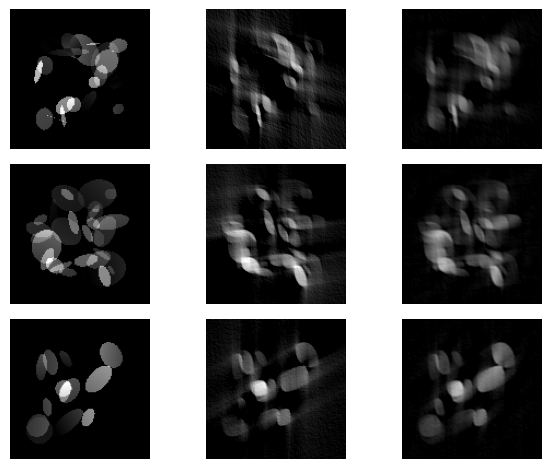

In [5]:
with torch.no_grad():
    _xdata80 = torch.tensor(test_xdata80[351]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
    _ydata80 = torch.tensor(test_ydata80[351]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
    y_pred80 = model80(_xdata80)

with torch.no_grad():
    _xdata100 = torch.tensor(test_xdata100[353]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
    _ydata100 = torch.tensor(test_ydata100[353]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
    y_pred100 = model100(_xdata100)

with torch.no_grad():

    _xdata120 = torch.tensor(test_xdata120[271]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
    _ydata120 = torch.tensor(test_ydata120[271]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
    y_pred120 = model120(_xdata120)
    
fig = plt.figure()
ax = fig.add_subplot(3, 3, 1)
plt.imshow(_ydata80[0, 0].cpu(), cmap='gray')
plt.axis('off')
ax = fig.add_subplot(3, 3, 2)
plt.imshow(_xdata80[0,0].cpu(), vmin=0, vmax=1, cmap='gray') 
plt.axis('off')
ax = fig.add_subplot(3, 3, 3)
plt.imshow(y_pred80[0, 0].cpu(),vmin=0, vmax=1, cmap='gray')
plt.axis('off')
ax = fig.add_subplot(3, 3, 4)
plt.imshow(_ydata100[0, 0].cpu(), cmap='gray')
plt.axis('off')
ax = fig.add_subplot(3, 3, 5)
plt.imshow(_xdata100[0,0].cpu(), vmin=0, vmax=1, cmap='gray') 
plt.axis('off')
ax = fig.add_subplot(3, 3, 6)
plt.imshow(y_pred100[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
plt.axis('off')
ax = fig.add_subplot(3, 3, 7)
plt.imshow(_ydata120[0, 0].cpu(), cmap='gray')
plt.axis('off')
ax = fig.add_subplot(3, 3, 8)
plt.imshow(_xdata120[0,0].cpu(),vmin=0, vmax=1, cmap='gray') 
plt.axis('off')
ax = fig.add_subplot(3, 3, 9)
plt.imshow(y_pred120[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
plt.axis('off')

fig.tight_layout()

(-0.5, 127.5, 127.5, -0.5)

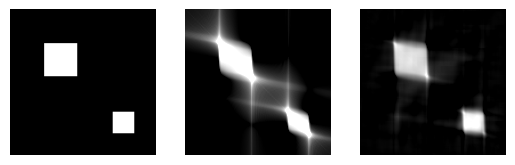

In [6]:
x_mat = scipy.io.loadmat(os.path.join('misc', 'sq_test_fbp80'))
x_train = x_mat['H']


y_mat = scipy.io.loadmat(os.path.join('misc', 'sq_test_original'))
y_train = y_mat['M']

x_data = torch.tensor(x_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
y_data = torch.tensor(y_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

with torch.no_grad():
    
    y_pred_data = model80(x_data)
    
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
plt.imshow(y_data[0,0].cpu(),cmap='gray')
plt.axis('off')
ax = fig.add_subplot(1, 3, 2)
plt.imshow(x_data[0,0].cpu(),vmin=0, vmax=1, cmap='gray') 
plt.axis('off')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(y_pred_data[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

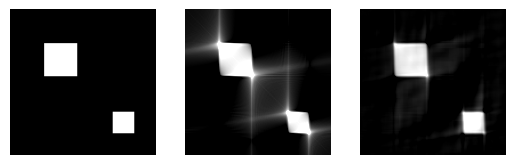

In [7]:
x_mat = scipy.io.loadmat(os.path.join('misc', 'sq_test_fbp100'))
x_train = x_mat['H']


y_mat = scipy.io.loadmat(os.path.join('misc', 'sq_test_original'))
y_train = y_mat['M']

x_data = torch.tensor(x_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
y_data = torch.tensor(y_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

with torch.no_grad():
    
    y_pred_data = model100(x_data)
    
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
plt.imshow(y_data[0,0].cpu(),cmap='gray')
plt.axis('off')
ax = fig.add_subplot(1, 3, 2)
plt.imshow(x_data[0,0].cpu(),vmin=0,vmax=1, cmap='gray') 
plt.axis('off')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(y_pred_data[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

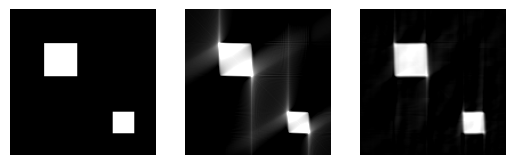

In [8]:
x_mat = scipy.io.loadmat(os.path.join('misc', 'sq_test_fbp120'))
x_train = x_mat['H']


y_mat = scipy.io.loadmat(os.path.join('misc', 'sq_test_original'))
y_train = y_mat['M']

x_data = torch.tensor(x_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
y_data = torch.tensor(y_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

with torch.no_grad():
    y_pred_data = model120(x_data)
    
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
plt.imshow(y_data[0,0].cpu(),cmap='gray')
plt.axis('off')
ax = fig.add_subplot(1, 3, 2)
plt.imshow(x_data[0,0].cpu(), vmin=0, vmax=1, cmap='gray') 
plt.axis('off')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(y_pred_data[0, 0].cpu(),vmin=0, vmax=1, cmap='gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

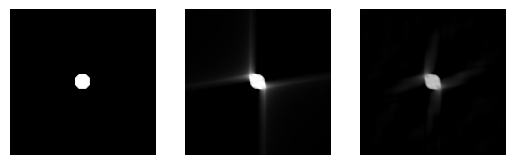

In [9]:
x_mat = scipy.io.loadmat(os.path.join('misc', 'circ_test7_fbp100'))
x_train = x_mat['H']


y_mat = scipy.io.loadmat(os.path.join('misc', 'circ_test7_original'))
y_train = y_mat['M']

x_data = torch.tensor(x_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
y_data = torch.tensor(y_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

with torch.no_grad():

    y_pred_data = model100(x_data)
    
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
plt.imshow(y_data[0,0].cpu(),cmap='gray')
plt.axis('off')
ax = fig.add_subplot(1, 3, 2)

plt.imshow(x_data[0,0].cpu(), vmin= 0, vmax=1, cmap='gray') 
plt.axis('off')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(y_pred_data[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

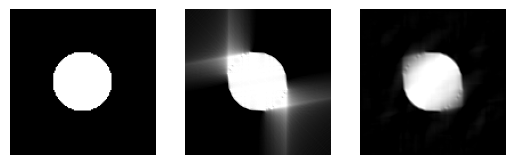

In [10]:
x_mat = scipy.io.loadmat(os.path.join('misc', 'circ_test26_fbp100'))
x_train = x_mat['H']

y_mat = scipy.io.loadmat(os.path.join('misc', 'circ_test26_original'))
y_train = y_mat['M']

x_data = torch.tensor(x_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
y_data = torch.tensor(y_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

with torch.no_grad():
    
    y_pred_data = model100(x_data)
    
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
plt.imshow(y_data[0,0].cpu(),cmap='gray')
plt.axis('off')
ax = fig.add_subplot(1, 3, 2)
plt.imshow(x_data[0,0].cpu(),vmin=0,vmax=1,cmap='gray') 
plt.axis('off')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(y_pred_data[0, 0].cpu(),vmin=0, vmax=1,cmap='gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

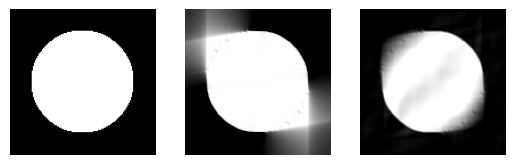

In [11]:
x_mat = scipy.io.loadmat(os.path.join('misc', 'circ_test45_fbp100'))
#     print(x_mat)
x_train = x_mat['H']


y_mat = scipy.io.loadmat(os.path.join('misc', 'circ_test45_original'))
y_train = y_mat['M']

x_data = torch.tensor(x_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
y_data = torch.tensor(y_train).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

with torch.no_grad():
    
    y_pred_data = model100(x_data)
    
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
plt.imshow(y_data[0,0].cpu(),cmap='gray')
plt.axis('off')
ax = fig.add_subplot(1, 3, 2)
plt.imshow(x_data[0,0].cpu(), vmin=0,vmax=1, cmap='gray') 
plt.axis('off')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(y_pred_data[0, 0].cpu(), vmin=0, vmax=1,cmap='gray')
plt.axis('off')